# Phase 1: Static ASL Training & Ablations

### Imports

In [3]:
# Standard PyTorch + Torchvision stack
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

# Reproducibility (essential for research and debugging)
import random
SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Note: For complete reproducibility, you may also need:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Device (GPU if available)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

# Loading data
import numpy as np
import kagglehub
import os
from sklearn.model_selection import train_test_split

Using device: cpu


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### ResNet-18

In [4]:
# Load ResNet-18
res18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Vedh/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


### Preprocessing

In [5]:
# ImageNet channel-wise statistics (computed over millions of images)
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # Mean per channel (R, G, B)
IMAGENET_STD  = [0.229, 0.224, 0.225]  # Std dev per channel

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 64
SEED = 429
LIMIT_PER_CLASS = 5

# Download data
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
data_dir = os.path.join(path, "asl_alphabet_train", "asl_alphabet_train")

# Training transforms
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Validation transforms
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Load dataset
raw_dataset = datasets.ImageFolder(root=data_dir) 

# 5 images per class
indices_to_use = []
targets = np.array(raw_dataset.targets)
classes = np.unique(targets)

for cls in classes:
    cls_indices = np.where(targets == cls)[0]
    indices_to_use.extend(cls_indices[:LIMIT_PER_CLASS])

# Get labels
subset_labels = targets[indices_to_use]

# 80/20 split
train_idx, val_idx = train_test_split(
    indices_to_use, 
    test_size=0.2, 
    stratify=subset_labels, 
    random_state=SEED
)

train_source = datasets.ImageFolder(root=data_dir, transform=train_tf)
val_source   = datasets.ImageFolder(root=data_dir, transform=val_tf)

# Final subsets
full_train_source = datasets.ImageFolder(root=data_dir, transform=train_tf)
full_val_source   = datasets.ImageFolder(root=data_dir, transform=val_tf)

train_ds = Subset(full_train_source, train_idx)
val_ds   = Subset(full_val_source, val_idx)

train_ds.classes = train_source.classes
val_ds.classes = val_source.classes

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

NUM_CLASSES = 29
print(f' Dataset: {len(train_ds):,} train, {len(val_ds):,} val')
print(f' Classes: {train_ds.classes}')

100%|██████████| 1.03G/1.03G [05:41<00:00, 3.22MB/s]

Extracting files...


 Dataset: 116 train, 29 val
 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


### Adapt ResNet-18 for ASL

In [13]:
# Start with ImageNet-pretrained weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Examine the original classifier
print(" Original FC layer:")
print(f"  Input features: {model.fc.in_features}")
print(f"  Output features: {model.fc.out_features} (ImageNet classes)")

# Replace with our custom classifier
# The in_features must match (512 for ResNet-18's final feature size)
# The NUM_CLASSES will change for other datasets
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

print("\n New FC layer:")
print(f"  Input features: {model.fc.in_features}")
print(f"  Output features: {model.fc.out_features} (our classes)")

# Move model to GPU if available
model = model.to(DEVICE)

 Original FC layer:
  Input features: 512
  Output features: 1000 (ImageNet classes)

 New FC layer:
  Input features: 512
  Output features: 29 (our classes)


### Freezing and Unfreezing

In [14]:
def set_requires_grad(module: nn.Module, requires_grad: bool):
    """
    Recursively set requires_grad for all parameters in a module.
    
    Args:
        module: PyTorch module (layer, block, or entire model)
        requires_grad: True to unfreeze (train), False to freeze
    """
    for param in module.parameters():
        param.requires_grad = requires_grad
    
    # Print status
    param_count = sum(p.numel() for p in module.parameters())
    status = "UNFROZEN (trainable)" if requires_grad else "FROZEN"
    print(f"  {module.__class__.__name__}: {param_count:,} parameters {status}")

### Training and Evaluation Functions

In [15]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer):
    """
    Train for one epoch.
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.train()  # Enable dropout, batch norm training mode
    
    total_samples = 0
    correct_predictions = 0
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(loader):
        # Move data to device (GPU/CPU)
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Forward pass
        optimizer.zero_grad()  # Clear previous gradients
        logits = model(images)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        
        # Track metrics
        running_loss += loss.item() * images.size(0)
        predictions = logits.argmax(dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += images.size(0)
        
        # Optional: Print progress
        if batch_idx % 100 == 0:
            print(f"    Batch {batch_idx}/{len(loader)}, "
                  f"Loss: {loss.item():.4f}")
    
    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

@torch.no_grad()  # Decorator disables gradient computation
def evaluate(model, loader):
    """
    Evaluate model on validation/test set.
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.eval()  # Disable dropout, batch norm eval mode
    
    total_samples = 0
    correct_predictions = 0
    running_loss = 0.0
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Forward pass only (no backward)
        logits = model(images)
        loss = criterion(logits, labels)
        
        # Track metrics
        running_loss += loss.item() * images.size(0)
        predictions = logits.argmax(dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += images.size(0)
    
    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

### Phase 1.1: Head-Only Fine Tuning

In [ ]:
# Hyperparameters for Phase 1
EPOCHS_HEAD_ONLY = 3    
LR_HEAD = 1e-3          

print("\n" + "="*60)
print(" PHASE 1: HEAD-ONLY FINE-TUNING")
print("="*60)

# Step 1: Freeze entire model
print("\n Freezing all layers...")
set_requires_grad(model, False)

# Step 2: Unfreeze only the classifier head
print("\n Unfreezing classifier head...")
set_requires_grad(model.fc, True)

# Step 3: Create optimizer for ONLY trainable parameters
# filter() ensures we only optimize parameters with requires_grad=True
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=LR_HEAD)

print(f"\n Optimizer setup:")
print(f"   Learning rate: {LR_HEAD}")
print(f"   Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Step 4: Training loop
print("\n Training progress:")
print("-" * 60)

best_val_acc = 0.0
for epoch in range(1, EPOCHS_HEAD_ONLY + 1):
    print(f"\nEpoch {epoch}/{EPOCHS_HEAD_ONLY}")
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader)
    
    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Optional: Save best model
        torch.save(model.state_dict(), 'best_model_phase1.pth')
    
    print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.3f}")
    print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.3f} "
          f"{' New best!' if val_acc == best_val_acc else ''}")

print("\n Phase 1 Complete!")
print(f"   Best validation accuracy: {best_val_acc:.3f}")


 PHASE 1: HEAD-ONLY FINE-TUNING

 Freezing all layers...
  ResNet: 11,191,389 parameters FROZEN

 Unfreezing classifier head...
  Linear: 14,877 parameters UNFROZEN (trainable)

 Optimizer setup:
   Learning rate: 0.001
   Trainable params: 14,877

 Training progress:
------------------------------------------------------------

Epoch 1/3
    Batch 0/2, Loss: 3.5232
   Train: Loss=3.5795, Acc=0.009
   Val:   Loss=3.4232, Acc=0.034  New best!

Epoch 2/3
    Batch 0/2, Loss: 3.2779
   Train: Loss=3.2659, Acc=0.086
   Val:   Loss=3.3179, Acc=0.000 

Epoch 3/3
    Batch 0/2, Loss: 3.0208
   Train: Loss=3.0830, Acc=0.147
   Val:   Loss=3.2180, Acc=0.069  New best!

 Phase 1 Complete!
   Best validation accuracy: 0.069


### Phase 1.2: Unfreeze Layer 4 + Head Fine-Tuning

In [ ]:
# Hyperparameters for Phase 1.2
EPOCHS_LAYER4_HEAD = 3  # Number of epochs for this phase
LR_LAYER4_HEAD = 1e-4    # A smaller learning rate is typical for unfreezing internal layers

print("\n" + "="*60)
print(" PHASE 1.2: LAYER 4 + HEAD FINE-TUNING")
print("="*60)

# Step 1: Freeze entire model (a safe starting point)
# The model is currently frozen from Phase 1.1, but it's good practice
print("\n Freezing all layers...")
set_requires_grad(model, False)

# Step 2: Unfreeze the final residual block (layer4) and the classifier head (fc)
print("\n Unfreezing Layer 4...")
set_requires_grad(model.layer4, True)

print(" Unfreezing classifier head...")
set_requires_grad(model.fc, True)

# Step 3: Create optimizer for ONLY newly trainable parameters
# Note: It's crucial to filter model.parameters() again for the *current* trainable set
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=LR_LAYER4_HEAD)

print(f"\n Optimizer setup:")
print(f"   Learning rate: {LR_LAYER4_HEAD}")
# Display the total number of trainable parameters
total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Trainable params: {total_trainable:,}")

# Step 4: Training loop
print("\n Training progress:")
print("-" * 60)

# Use the best validation accuracy from the previous phase as a starting point
current_best_val_acc = best_val_acc

for epoch in range(1, EPOCHS_LAYER4_HEAD + 1):
    print(f"\nEpoch {epoch}/{EPOCHS_LAYER4_HEAD}")
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader)
    
    # Track best model
    is_new_best = val_acc > current_best_val_acc
    if is_new_best:
        current_best_val_acc = val_acc
        # Optional: Save best model
        torch.save(model.state_dict(), 'best_model_phase1_2.pth')
    
    print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.3f}")
    print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.3f} "
          f"{' New best!' if is_new_best else ''}")

print("\n Phase 1.2 Complete!")
print(f"   Best validation accuracy after this phase: {current_best_val_acc:.3f}")


 PHASE 1.2: LAYER 4 + HEAD FINE-TUNING

 Freezing all layers...
  ResNet: 11,191,389 parameters FROZEN

 Unfreezing Layer 4...
  Sequential: 8,393,728 parameters UNFROZEN (trainable)
 Unfreezing classifier head...
  Linear: 14,877 parameters UNFROZEN (trainable)

 Optimizer setup:
   Learning rate: 0.0001
   Trainable params: 8,408,605

 Training progress:
------------------------------------------------------------

Epoch 1/3
    Batch 0/2, Loss: 2.9511
   Train: Loss=2.8647, Acc=0.259
   Val:   Loss=2.9408, Acc=0.310  New best!

Epoch 2/3
    Batch 0/2, Loss: 2.1329
   Train: Loss=2.0368, Acc=0.845
   Val:   Loss=2.6408, Acc=0.552  New best!

Epoch 3/3
    Batch 0/2, Loss: 1.5216
   Train: Loss=1.4439, Acc=0.974
   Val:   Loss=2.3475, Acc=0.690  New best!

 Phase 1.2 Complete!
   Best validation accuracy after this phase: 0.690


### Phase 1.3: Unfreeze Layer 3, Layer 4, & Head Fine-Tuning

In [ ]:
# Hyperparameters for Phase 1.3
EPOCHS_LAYER3_4_HEAD = 3  # Number of epochs for this phase
LR_LAYER3_4_HEAD = 1e-5    # Use a very small learning rate for deeper unfreezing

print("\n" + "="*60)
print(" PHASE 1.3: LAYER 3 + LAYER 4 + HEAD FINE-TUNING")
print("="*60)

# Optional: Load best weights from previous phase if saved externally
# if os.path.exists('best_model_phase1_2.pth'):
#     model.load_state_dict(torch.load('best_model_phase1_2.pth'))
#     print("\n Loaded best weights from Phase 1.2.")
# else:
#     print("\n Continuing from current model state.")

# Step 1: Freeze entire model (a safe starting point)
print("\n Freezing all layers...")
set_requires_grad(model, False)

# Step 2: Unfreeze Layer 3, Layer 4, and the classifier head (fc)
print("\n Unfreezing Layer 3...")
set_requires_grad(model.layer3, True)

print(" Unfreezing Layer 4...")
set_requires_grad(model.layer4, True)

print(" Unfreezing classifier head...")
set_requires_grad(model.fc, True)

# Step 3: Create optimizer for ONLY newly trainable parameters
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=LR_LAYER3_4_HEAD)

print(f"\n Optimizer setup:")
print(f"   Learning rate: {LR_LAYER3_4_HEAD}")
# Display the total number of trainable parameters
total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Trainable params: {total_trainable:,}")
print(f"   Approximate trainable layers: layer3, layer4, fc")

# Step 4: Training loop
print("\n Training progress:")
print("-" * 60)

# Initialize best accuracy tracking (assuming 'current_best_val_acc' holds the best from 1.2)
# If this is run directly after 1.2, you might re-initialize this variable
current_best_val_acc = 0.0 # Re-evaluate best if not continuing from the same run

for epoch in range(1, EPOCHS_LAYER3_4_HEAD + 1):
    print(f"\nEpoch {epoch}/{EPOCHS_LAYER3_4_HEAD}")
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader)
    
    # Track best model
    is_new_best = val_acc > current_best_val_acc
    if is_new_best:
        current_best_val_acc = val_acc
        # Optional: Save best model
        torch.save(model.state_dict(), 'best_model_phase1_3.pth')
    
    print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.3f}")
    print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.3f} "
          f"{' New best!' if is_new_best else ''}")

print("\n Phase 1.3 Complete!")
print(f"   Best validation accuracy after this phase: {current_best_val_acc:.3f}")


 PHASE 1.3: LAYER 3 + LAYER 4 + HEAD FINE-TUNING

 Freezing all layers...
  ResNet: 11,191,389 parameters FROZEN

 Unfreezing Layer 3...
  Sequential: 2,099,712 parameters UNFROZEN (trainable)
 Unfreezing Layer 4...
  Sequential: 8,393,728 parameters UNFROZEN (trainable)
 Unfreezing classifier head...
  Linear: 14,877 parameters UNFROZEN (trainable)

 Optimizer setup:
   Learning rate: 1e-05
   Trainable params: 10,508,317
   Approximate trainable layers: layer3, layer4, fc

 Training progress:
------------------------------------------------------------

Epoch 1/3
    Batch 0/2, Loss: 1.0400
   Train: Loss=1.0701, Acc=1.000
   Val:   Loss=2.2700, Acc=0.724  New best!

Epoch 2/3
    Batch 0/2, Loss: 1.0226
   Train: Loss=1.0039, Acc=1.000
   Val:   Loss=2.2061, Acc=0.724 

Epoch 3/3
    Batch 0/2, Loss: 1.0227
   Train: Loss=0.9626, Acc=1.000
   Val:   Loss=2.1549, Acc=0.724 

 Phase 1.3 Complete!
   Best validation accuracy after this phase: 0.724


### Phase 1.4: Full Fine-Tuning (Unfreeze All Layers)

In [ ]:
# Hyperparameters for Phase 1.4
EPOCHS_FULL_FT = 3  # Number of epochs for this final phase
LR_FULL_FT = 1e-6    # A very small learning rate is crucial for full fine-tuning
CHECKPOINT_FILE_P1_4 = 'best_model_phase1_4.pth'

print("\n" + "="*60)
print(" PHASE 1.4: FULL FINE-TUNING (UNFREEZE ALL LAYERS)")
print("="*60)

# Since you haven't been saving weights, we continue from the current in-memory model state.
print("\n Continuing from current in-memory model state (best of Phase 1.3).")
# We'll need a quick evaluation to set the starting best accuracy.
_, current_best_val_acc = evaluate(model, val_loader)
print(f" Initial Val Acc: {current_best_val_acc:.3f}")

# Step 1: Unfreeze ALL layers in the entire model
print("\n Unfreezing the entire network...")
set_requires_grad(model, True)

# Step 2: Create optimizer for ALL parameters
# Since all parameters now have requires_grad=True, we pass them all.
trainable_params = model.parameters()
optimizer = optim.Adam(trainable_params, lr=LR_FULL_FT)

print(f"\n Optimizer setup:")
print(f"   Learning rate: {LR_FULL_FT}")
total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Total Trainable params: {total_trainable:,}")
print(f"   (This should be the total number of parameters in ResNet-18)")

# Step 3: Training loop
print("\n Training progress:")
print("-" * 60)

for epoch in range(1, EPOCHS_FULL_FT + 1):
    print(f"\nEpoch {epoch}/{EPOCHS_FULL_FT}")
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader)
    
    # Track and SAVE best model
    is_new_best = val_acc > current_best_val_acc
    if is_new_best:
        current_best_val_acc = val_acc
        
        # ⭐ SAVE THE CHECKPOINT ⭐
        torch.save(model.state_dict(), CHECKPOINT_FILE_P1_4)
        print(f"   SAVED new best model to {CHECKPOINT_FILE_P1_4}")
    
    print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.3f}")
    print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.3f} "
          f"{' New best!' if is_new_best else ''}")

print("\n Phase 1.4 Complete!")
print(f"   Final best validation accuracy: {current_best_val_acc:.3f}")


 PHASE 1.4: FULL FINE-TUNING (UNFREEZE ALL LAYERS)

 Continuing from current in-memory model state (best of Phase 1.3).
 Initial Val Acc: 0.724

 Unfreezing the entire network...
  ResNet: 11,191,389 parameters UNFROZEN (trainable)

 Optimizer setup:
   Learning rate: 1e-06
   Total Trainable params: 11,191,389
   (This should be the total number of parameters in ResNet-18)

 Training progress:
------------------------------------------------------------

Epoch 1/3
    Batch 0/2, Loss: 0.8973
   SAVED new best model to best_model_phase1_4.pth
   Train: Loss=0.9060, Acc=1.000
   Val:   Loss=2.1299, Acc=0.759  New best!

Epoch 2/3
    Batch 0/2, Loss: 0.8686
   Train: Loss=0.9209, Acc=1.000
   Val:   Loss=2.1112, Acc=0.759 

Epoch 3/3
    Batch 0/2, Loss: 0.8775
   Train: Loss=0.9001, Acc=1.000
   Val:   Loss=2.0967, Acc=0.759 

 Phase 1.4 Complete!
   Final best validation accuracy: 0.759


### Evaluation

In [20]:
# New Imports needed for comprehensive metrics
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

@torch.no_grad()
def evaluate_full_metrics(model, loader, phase_name, class_names):
    """
    Evaluates model and returns Accuracy, Macro-F1, and Confusion Matrix components.
    """
    model.eval()
    
    all_preds = []
    all_labels = []
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        logits = model(images)
        predictions = logits.argmax(dim=1)
        
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # --- Metrics Calculation ---
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n--- Results for {phase_name} ---")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Macro-F1: {macro_f1:.4f}")
    
    # --- Confusion Matrix Plotting ---
    plt.figure(figsize=(10, 8))
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {phase_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, macro_f1

--- 1. MODEL SELECTION: VALIDATION MACRO-F1 ---
Skipping T-A (Head Only): Checkpoint not found at best_model_phase1_1.pth
Skipping T-B (L4+Head): Checkpoint not found at best_model_phase1_2.pth
Skipping T-C (L3+L4+Head): Checkpoint not found at best_model_phase1_3.pth


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique clas


--- Results for Validation Set (S-A (Full FT)) ---
  Accuracy: 0.7586
  Macro-F1: 0.6897


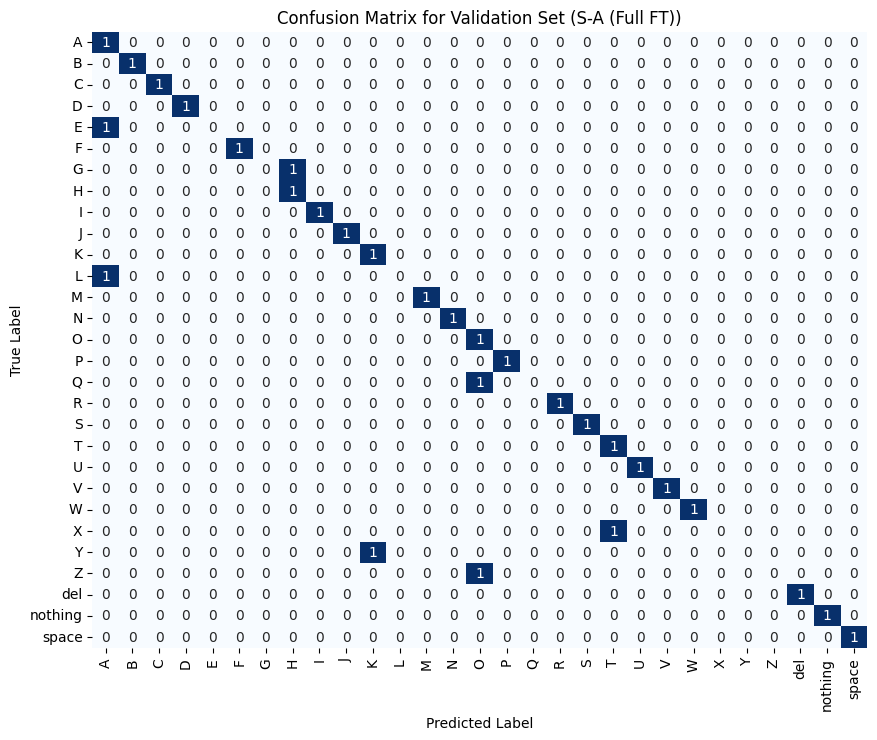


Model Selection Complete:
The best model based on Validation Macro-F1 is: **S-A (Full FT)**
Best Macro-F1: 0.6897


In [21]:
MODEL_CHECKPOINTS = {
    "T-A (Head Only)": 'best_model_phase1_1.pth',
    "T-B (L4+Head)": 'best_model_phase1_2.pth',
    "T-C (L3+L4+Head)": 'best_model_phase1_3.pth',
    "S-A (Full FT)": 'best_model_phase1_4.pth',
}

best_overall_f1 = -1.0
best_model_id = None
best_checkpoint_path = None
results = {}

print("--- 1. MODEL SELECTION: VALIDATION MACRO-F1 ---")
for model_id, path in MODEL_CHECKPOINTS.items():
    if not os.path.exists(path):
        print(f"Skipping {model_id}: Checkpoint not found at {path}")
        continue
    
    # Load model weights
    model.load_state_dict(torch.load(path))
    
    # Evaluate on Validation Set
    val_acc, val_f1 = evaluate_full_metrics(
        model, 
        val_loader, 
        f"Validation Set ({model_id})", 
        val_ds.classes
    )
    
    results[model_id] = {'Accuracy': val_acc, 'Macro-F1': val_f1}
    
    if val_f1 > best_overall_f1:
        best_overall_f1 = val_f1
        best_model_id = model_id
        best_checkpoint_path = path

print("\n" + "="*50)
print(f"Model Selection Complete:")
print(f"The best model based on Validation Macro-F1 is: **{best_model_id}**")
print(f"Best Macro-F1: {best_overall_f1:.4f}")
print("="*50)